# Appendix


Aayush Adhikari
220426@softwarica.edu.np

**In this notebook we predict medical cost using linear and polynomial regression with Pyspark.**

In [1]:
#this code sets a filter to ignore warning messages
import warnings
warnings.filterwarnings("ignore")

# Installing Pyspark

In [2]:
!pip install pyspark

# Initializing a SparkSession object

In [3]:
from pyspark.sql import SparkSession
spark= SparkSession.builder.master("local[*]").getOrCreate()
spark

# Importing the necessary packages

In [4]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import *
import seaborn as sns
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.feature import PolynomialExpansion

# Loading the insurance data

In the next two cells, we will first load the dataset and then write some code to find out the shape of our dataset.

In [5]:
#loading data
insurance_df=spark.read.load('insurance.csv',
                     format="csv",header="true",inferschema="true")
insurance_df.show(10)

+---+------+----+--------+------+---------+--------+
|age|   sex| bmi|children|smoker|   region|expenses|
+---+------+----+--------+------+---------+--------+
| 19|female|27.9|       0|   yes|southwest|16884.92|
| 18|  male|33.8|       1|    no|southeast| 1725.55|
| 28|  male|33.0|       3|    no|southeast| 4449.46|
| 33|  male|22.7|       0|    no|northwest|21984.47|
| 32|  male|28.9|       0|    no|northwest| 3866.86|
| 31|female|25.7|       0|    no|southeast| 3756.62|
| 46|female|33.4|       1|    no|southeast| 8240.59|
| 37|female|27.7|       3|    no|northwest| 7281.51|
| 37|  male|29.8|       2|    no|northeast| 6406.41|
| 60|female|25.8|       0|    no|northwest|28923.14|
+---+------+----+--------+------+---------+--------+
only showing top 10 rows



In [6]:
#shape of the data
num_rows =insurance_df.count()
num_cols = len(insurance_df.columns)
print("num rows: {}   ,   num cols: {}".format(num_rows,num_cols))

num rows: 1338   ,   num cols: 7


This data contains 7 columns. We use the features like age, sex, bmi, number of children, smoker or non-smoker, and region to predict the cost of insurance.

In [7]:
insurance_df.describe().show()

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|          expenses|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.665470852017993|  1.0949177877429|  null|     null|13270.422414050803|
| stddev|14.049960379216147|  null|  6.09838219000336|1.205492739781914|  null|     null|12110.011239706473|
|    min|                18|female|              16.0|                0|    no|northeast|           1121.87|
|    max|                64|  male|              53.1|                5|   yes|southwest|          63770.43|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+



# Preprocessing

First, we want to gain some information about our data. After running this code, we can find out the data type of each column.

In [10]:
insurance_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- expenses: double (nullable = true)



This code is performing some basic data cleaning operations like removing all the Null values and Duplicates and then we count the number of rows of the data.

In [11]:
#droping Null values and duplicates
insurance_df=insurance_df.dropna()
insurance_df

DataFrame[age: int, sex: string, bmi: double, children: int, smoker: string, region: string, expenses: double]

In [12]:
main_insurance_df = insurance_df.dropna()
insurance_df=insurance_df.dropDuplicates()
insurance_df.count()

1337

After removing the null and duplicate values, we see that the number of rows has reduced by one.

In this cell we convert our string columns 'region', 'sex', and 'smoker' to integers.

In [13]:
#string to int for region column
mapping = {"northeast": 0, "northwest": 1, "southeast": 2, "southwest": 3}
insurance_df = insurance_df.withColumn("region_int", when(insurance_df.region == "northeast", mapping["northeast"])
                   .when(insurance_df.region == "northwest", mapping["northwest"])
                   .when(insurance_df.region == "southeast", mapping["southeast"])
                   .otherwise(mapping["southwest"]))
insurance_df=insurance_df.drop("region")

#string to int for sex column
insurance_df = insurance_df.withColumn("sex_int", when(insurance_df.sex == "female", 1).otherwise(0))
insurance_df=insurance_df.drop("sex")

#string to int for smoker column
insurance_df = insurance_df.withColumn("smoker_int", when(insurance_df.smoker == "yes", 1).otherwise(0))
insurance_df=insurance_df.drop("smoker")

insurance_df.show(10)

+---+----+--------+--------+----------+-------+----------+
|age| bmi|children|expenses|region_int|sex_int|smoker_int|
+---+----+--------+--------+----------+-------+----------+
| 24|27.6|       0|18955.22|         3|      1|         0|
| 34|34.2|       0| 3935.18|         2|      0|         0|
| 32|23.7|       1|17626.24|         2|      1|         0|
| 30|31.4|       1| 3659.35|         3|      0|         0|
| 18|40.3|       0|  2217.6|         0|      1|         0|
| 39|34.1|       3| 7418.52|         3|      1|         0|
| 41|32.6|       3| 7954.52|         3|      1|         0|
| 24|29.9|       0| 2850.68|         1|      1|         0|
| 39|34.1|       2|23563.02|         2|      0|         0|
| 42|37.9|       0| 6474.01|         3|      1|         0|
+---+----+--------+--------+----------+-------+----------+
only showing top 10 rows



# Correlation Matrix

In this cell we calculate the correlation matrix for the numerical columns in our DataFrame using the "corr" function from the "stat" module of PySpark.

In [14]:
#Calculating the correlation matrix
columns= insurance_df.columns
correlation_matrix= np.zeros((len(columns),len(columns)))
for i in range(len(columns)):
      for j in range(len(columns)):
            correlation_matrix[i][j]=insurance_df.stat.corr(columns[i],columns[j])

<Axes: >

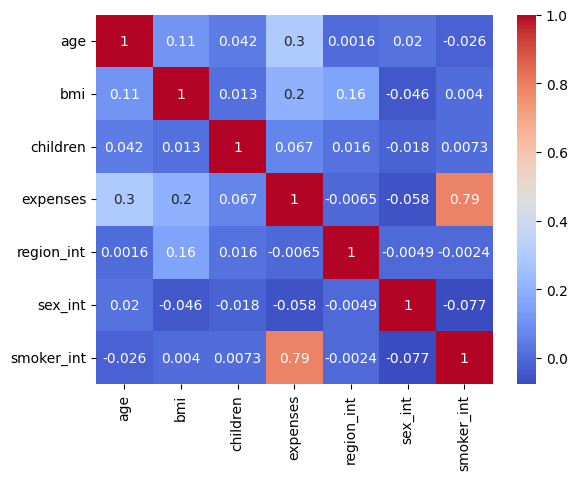

In [15]:
sns.heatmap(correlation_matrix,annot=True, cmap='coolwarm',xticklabels=columns,yticklabels=columns)

# Univariate Analysis

In the following four cells, we generate bar plots to visualize the frequency counts for several columns in the DataFrame. Specifically, we plot the frequency counts for the 'smoker_int', 'children', 'sex_int', and 'region_int' columns

In [16]:
pandas_df = insurance_df.toPandas()
pandas_df

,age,bmi,children,expenses,region_int,sex_int,smoker_int
0,24,27.6,0,18955.22,3,1,0
1,34,34.2,0,3935.18,2,0,0
2,32,23.7,1,17626.24,2,1,0
3,30,31.4,1,3659.35,3,0,0
4,18,40.3,0,2217.60,0,1,0
...,...,...,...,...,...,...,...
1332,31,31.1,3,5425.02,1,0,0
1333,19,28.4,1,1842.52,3,0,0
1334,18,20.8,0,1607.51,2,1,0
1335,51,34.1,0,9283.56,2,1,0


In the following two cells, we generate density plots to visualize the distribution of values in the 'age' and 'bmi' columns.

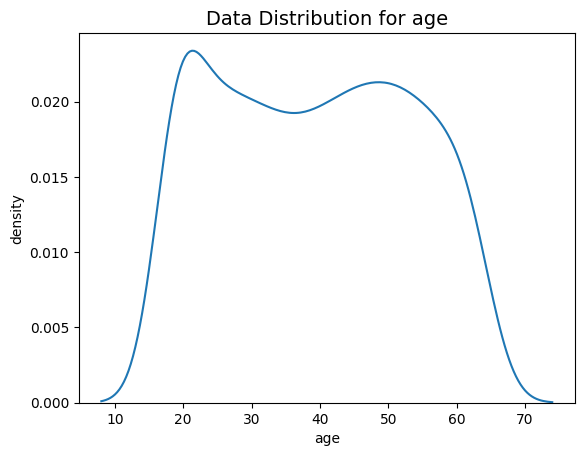

In [17]:
sns.distplot(pandas_df["age"], hist=False)
plt.title("Data Distribution for age", fontsize=14)
plt.xlabel("age")
plt.ylabel("density")
plt.show()

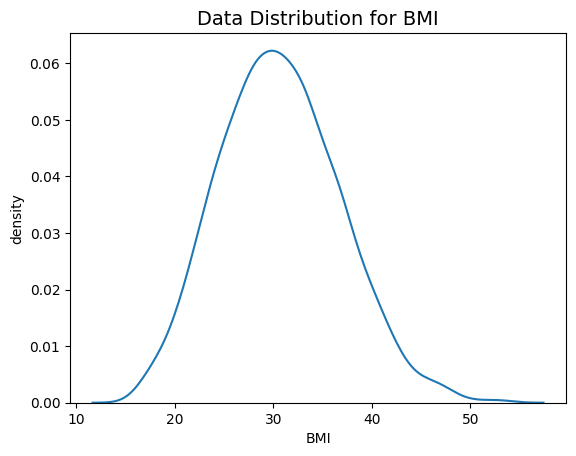

In [18]:
sns.distplot(pandas_df["bmi"], hist=False)
plt.title("Data Distribution for BMI", fontsize=14)
plt.xlabel("BMI")
plt.ylabel("density")
plt.show()

## Bivariate & Multivariate Analysis

<Figure size 1500x1500 with 0 Axes>

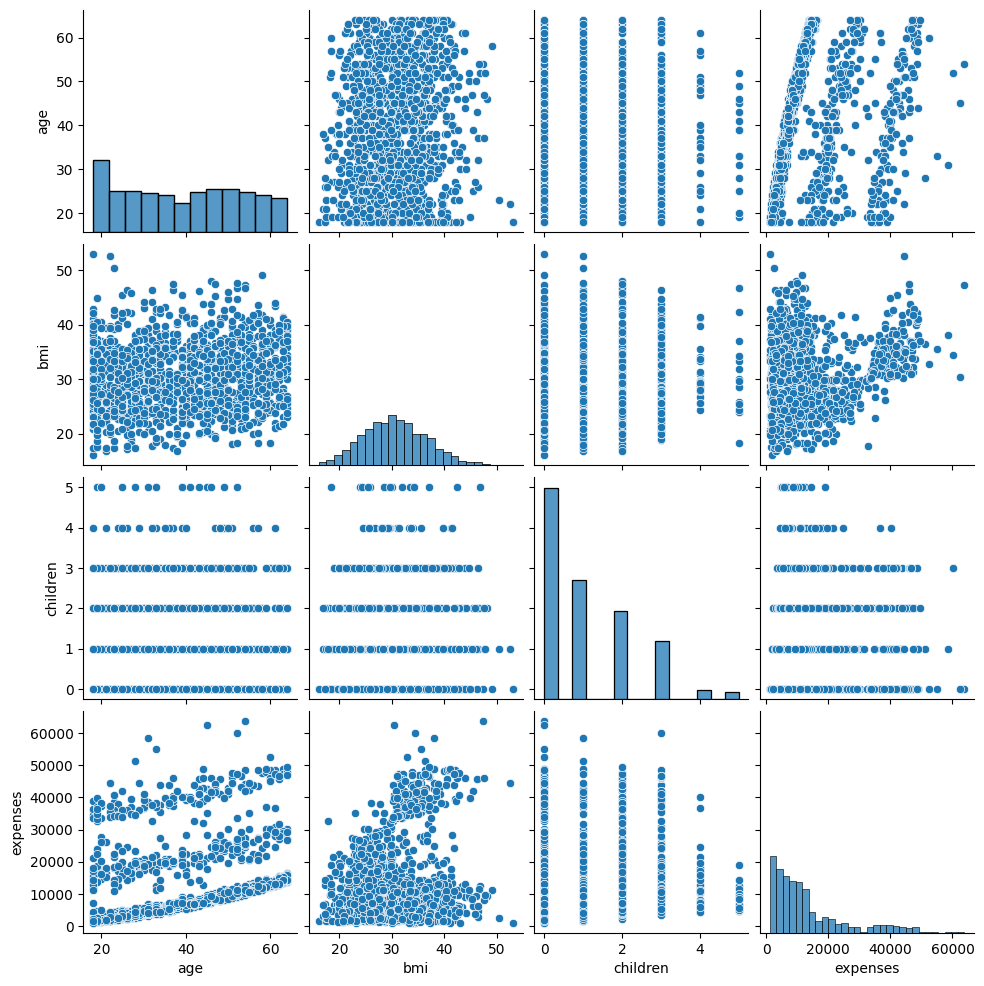

In [19]:
plt.figure(figsize=(15, 15))
sns.pairplot(main_insurance_df.toPandas())
plt.show()

In [20]:
#multi variate data analysis
main_insurance_df.toPandas().groupby(['region','sex','smoker']).expenses.mean()

region     sex     smoker
northeast  female  no         9640.427121
                   yes       28032.045517
           male    no         8664.042640
                   yes       30926.252895
northwest  female  no         8786.998519
                   yes       29670.824828
           male    no         8320.689167
                   yes       30713.180690
southeast  female  no         8440.205396
                   yes       33034.821389
           male    no         7609.003731
                   yes       36029.839636
southwest  female  no         8234.091702
                   yes       31687.988571
           male    no         7778.906111
                   yes       32598.863784
Name: expenses, dtype: float64

In [21]:
#multi variate data analysis
main_insurance_df.toPandas().groupby(['region','sex','smoker']).expenses.sum()

region     sex     smoker
northeast  female  no        1272536.38
                   yes        812929.32
           male    no        1083005.33
                   yes       1175197.61
northwest  female  no        1186244.80
                   yes        860453.92
           male    no        1098330.97
                   yes        890682.24
southeast  female  no        1173188.55
                   yes       1189253.57
           male    no        1019606.50
                   yes       1981641.18
southwest  female  no        1161006.93
                   yes        665447.76
           male    no         980142.17
                   yes       1206157.96
Name: expenses, dtype: float64

# Simple Linear Regression

**First model: with all of the features**

In [22]:
vectorassembler1=VectorAssembler(inputCols= ["age","bmi","children","region_int","sex_int","smoker_int"],
                                outputCol="feature_vector")

insurance_vector1=vectorassembler1.transform(insurance_df)
insurance_vector1=insurance_vector1.select(["feature_vector","expenses"])

insurance_vector1.show()

+--------------------+--------+
|      feature_vector|expenses|
+--------------------+--------+
|[24.0,27.6,0.0,3....|18955.22|
|[34.0,34.2,0.0,2....| 3935.18|
|[32.0,23.7,1.0,2....|17626.24|
|[30.0,31.4,1.0,3....| 3659.35|
|[18.0,40.3,0.0,0....|  2217.6|
|[39.0,34.1,3.0,3....| 7418.52|
|[41.0,32.6,3.0,3....| 7954.52|
|[24.0,29.9,0.0,1....| 2850.68|
|[39.0,34.1,2.0,2....|23563.02|
|[42.0,37.9,0.0,3....| 6474.01|
|[61.0,31.6,0.0,2....|12557.61|
|[45.0,36.3,2.0,2....| 8527.53|
|[24.0,24.2,0.0,1....| 2842.76|
|[36.0,29.9,0.0,2....| 4889.04|
|[29.0,37.3,2.0,2....| 4058.12|
|[33.0,27.5,2.0,1....| 5261.47|
|[20.0,33.3,0.0,2....| 1391.53|
|[20.0,29.7,0.0,1....| 1769.53|
|[54.0,25.1,3.0,3....| 25382.3|
|(6,[0,1],[31.0,30...| 3857.76|
+--------------------+--------+
only showing top 20 rows



In [23]:
#training the model
train_set1,test_set1=insurance_vector1.randomSplit([0.8,0.2])

#training the model
model1=LinearRegression(labelCol="expenses", featuresCol="feature_vector")
model_trained1=model1.fit(train_set1)

#predicting
model_predict1=model_trained1.transform(test_set1)
model_predict1.show()

+--------------------+--------+------------------+
|      feature_vector|expenses|        prediction|
+--------------------+--------+------------------+
|(6,[0,1],[18.0,23...| 1705.62| 676.2750432969333|
|(6,[0,1],[18.0,39...|12890.06| 5756.433156205365|
|(6,[0,1],[20.0,40...| 1984.45| 6740.787629169952|
|(6,[0,1],[23.0,23...| 2395.17|1975.0335528208652|
|(6,[0,1],[23.0,24...|  2396.1|2207.4590873983743|
|(6,[0,1],[26.0,29...| 2897.32| 4646.896582952088|
|(6,[0,1],[43.0,26...| 6837.37| 7900.547842445905|
|(6,[0,1],[45.0,39...|  7448.4|13002.154642212097|
|(6,[0,1],[51.0,22...| 9361.33| 8783.230136999855|
|(6,[0,1],[52.0,33...| 9722.77|12662.179448754441|
|(6,[0,1],[54.0,24...|10422.92|10093.743607462811|
|(6,[0,1],[58.0,25...|11931.13|11531.194188643402|
|(6,[0,1],[60.0,28...| 30260.0|13179.621617543735|
|(6,[0,1],[61.0,33...|13143.86|15199.166652678237|
|[18.0,17.3,2.0,0....|12829.46|23298.663118797806|
|[18.0,26.3,0.0,0....| 2198.19|1392.0963850964108|
|[18.0,27.3,3.0,2....|18223.45|

In [24]:
#calculating errors for Linear Regression
metric_name=["mae","r2"]
for metric in metric_name:
  evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="expenses", metricName=metric)
  metric_value=evaluator.evaluate(model_predict1)
  print("{}: {}".format(metric,metric_value))

mae: 4068.1932855221
r2: 0.7407389047308485


**Second model: removing some of the features**

Here, we remove the features that have low correlation with the target value in the hope that our model will improve. Specifically, we remove features such as number of children, sex, and region that have very low correlation with our target variable.

In [25]:
vectorassembler2=VectorAssembler(inputCols= ["age","bmi","smoker_int"],
                                outputCol="feature_vector2")

insurance_vector2=vectorassembler2.transform(insurance_df)
insurance_vector2=insurance_vector2.select(["feature_vector2","expenses"])
insurance_vector2.show()

+---------------+--------+
|feature_vector2|expenses|
+---------------+--------+
|[24.0,27.6,0.0]|18955.22|
|[34.0,34.2,0.0]| 3935.18|
|[32.0,23.7,0.0]|17626.24|
|[30.0,31.4,0.0]| 3659.35|
|[18.0,40.3,0.0]|  2217.6|
|[39.0,34.1,0.0]| 7418.52|
|[41.0,32.6,0.0]| 7954.52|
|[24.0,29.9,0.0]| 2850.68|
|[39.0,34.1,0.0]|23563.02|
|[42.0,37.9,0.0]| 6474.01|
|[61.0,31.6,0.0]|12557.61|
|[45.0,36.3,0.0]| 8527.53|
|[24.0,24.2,0.0]| 2842.76|
|[36.0,29.9,0.0]| 4889.04|
|[29.0,37.3,0.0]| 4058.12|
|[33.0,27.5,0.0]| 5261.47|
|[20.0,33.3,0.0]| 1391.53|
|[20.0,29.7,0.0]| 1769.53|
|[54.0,25.1,1.0]| 25382.3|
|[31.0,30.9,0.0]| 3857.76|
+---------------+--------+
only showing top 20 rows



In [26]:
#splitting into train and test
train_set2,test_set2=insurance_vector2.randomSplit([0.8,0.2])

#training the model
model2=LinearRegression(labelCol="expenses", featuresCol="feature_vector2")
model_trained2=model2.fit(train_set2)

#predicting
model_predict2=model_trained2.transform(test_set2)
model_predict2.show()

+---------------+--------+-------------------+
|feature_vector2|expenses|         prediction|
+---------------+--------+-------------------+
|[18.0,21.6,1.0]|13747.87|  23517.82096601186|
|[18.0,23.1,0.0]|  1704.7|  285.6668316743908|
|[18.0,24.1,0.0]|  2201.1|  596.8510082761786|
|[18.0,25.2,1.0]|15518.18|  24638.08400177829|
|[18.0,26.7,0.0]| 1615.77| 1405.9298674408255|
|[18.0,30.0,0.0]| 1720.35|  2432.837650226724|
|[18.0,31.1,0.0]| 1621.88|   2775.14024448869|
|[18.0,33.5,1.0]|34617.84| 27220.912667573124|
|[18.0,38.7,0.0]| 3393.36|  5140.139986662272|
|[18.0,39.8,0.0]| 1633.96|  5482.442580924237|
|[18.0,40.3,0.0]| 1634.57|  5638.034669225131|
|[18.0,43.0,0.0]|  1149.4|  6478.231946049958|
|[19.0,17.5,0.0]| 1621.34| -1185.299241897761|
|[19.0,17.8,0.0]| 1727.79|-1091.9439889172263|
|[19.0,19.8,0.0]| 1241.57| -469.5756357136506|
|[19.0,25.2,0.0]| 1632.04| 1210.8189179359997|
|[19.0,25.6,0.0]| 2221.56| 1335.2925885767163|
|[19.0,29.8,0.0]| 1744.47| 2642.2661303042223|
|[19.0,30.0,1

In [27]:
#calculating errors for Linear Regression with feature engineering
for metric in metric_name:
  evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="expenses", metricName=metric)
  metric_value=evaluator.evaluate(model_predict2)
  print("{}: {}".format(metric,metric_value))

mae: 4383.219027148542
r2: 0.7368014470081813


# Polynomial regression

We use polynomial regression of degree 2 to predict insurance cost, and then we evaluate the error metrics of the model.

In [28]:
degree = 2  # Degree of the polynomial
vectorassembler3 = VectorAssembler(inputCols= ["age","bmi","smoker_int"],
                                outputCol="feature_vector3")
insurance_vector3=vectorassembler3.transform(insurance_df)
poly_expansion = PolynomialExpansion(degree=degree, inputCol="feature_vector3", outputCol="poly_features")
df_poly = poly_expansion.transform(insurance_vector3)
df_poly=df_poly.select(["poly_features","expenses"])

df_poly.show()

+--------------------+--------+
|       poly_features|expenses|
+--------------------+--------+
|[24.0,576.0,27.6,...|18955.22|
|[34.0,1156.0,34.2...| 3935.18|
|[32.0,1024.0,23.7...|17626.24|
|[30.0,900.0,31.4,...| 3659.35|
|[18.0,324.0,40.3,...|  2217.6|
|[39.0,1521.0,34.1...| 7418.52|
|[41.0,1681.0,32.6...| 7954.52|
|[24.0,576.0,29.9,...| 2850.68|
|[39.0,1521.0,34.1...|23563.02|
|[42.0,1764.0,37.9...| 6474.01|
|[61.0,3721.0,31.6...|12557.61|
|[45.0,2025.0,36.3...| 8527.53|
|[24.0,576.0,24.2,...| 2842.76|
|[36.0,1296.0,29.9...| 4889.04|
|[29.0,841.0,37.3,...| 4058.12|
|[33.0,1089.0,27.5...| 5261.47|
|[20.0,400.0,33.3,...| 1391.53|
|[20.0,400.0,29.7,...| 1769.53|
|[54.0,2916.0,25.1...| 25382.3|
|[31.0,961.0,30.9,...| 3857.76|
+--------------------+--------+
only showing top 20 rows



In [29]:
#splitting into train and test
train_set3,test_set3=df_poly.randomSplit([0.8,0.2])

#training the model
model3=LinearRegression(labelCol="expenses", featuresCol="poly_features")
model_trained3=model3.fit(train_set3)

#predicting
model_predict3=model_trained3.transform(test_set3)
model_predict3.show()

+--------------------+--------+------------------+
|       poly_features|expenses|        prediction|
+--------------------+--------+------------------+
|[18.0,324.0,17.3,...|12829.46| 6024.512043748946|
|[18.0,324.0,21.6,...|13747.87|13234.184606480703|
|[18.0,324.0,23.2,...| 1121.87| 3496.609586517052|
|[18.0,324.0,25.5,...|  1708.0| 3705.642061342167|
|[18.0,324.0,27.3,...|18223.45|22236.826691488845|
|[18.0,324.0,28.3,...|11272.33| 3821.233174406838|
|[18.0,324.0,30.3,...| 2203.74|3810.4313952589273|
|[18.0,324.0,31.4,...| 4561.19|3771.3257300309524|
|[18.0,324.0,31.7,...|34303.17|28754.023861099027|
|[18.0,324.0,33.3,...| 1135.94| 3648.343007930207|
|[18.0,324.0,33.9,...|11482.63|3594.9177869850773|
|[18.0,324.0,38.2,...| 36307.8| 37692.63462047012|
|[18.0,324.0,38.3,...| 1631.82| 2989.167112764051|
|[19.0,361.0,24.6,...| 1837.24|3798.5551235239454|
|[19.0,361.0,25.2,...| 1632.04|3848.2835020703587|
|[19.0,361.0,27.8,...| 1635.73|3982.8551971842116|
|[19.0,361.0,28.3,...|17081.08|

In [30]:
#calculating errors for polynomial regression
for metric in metric_name:
  evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="expenses", metricName=metric)
  metric_value=evaluator.evaluate(model_predict3)
  print("{}: {}".format(metric,metric_value))

mae: 2851.99571505807
r2: 0.8754304028301628


Text(0, 0.5, 'y_pred')

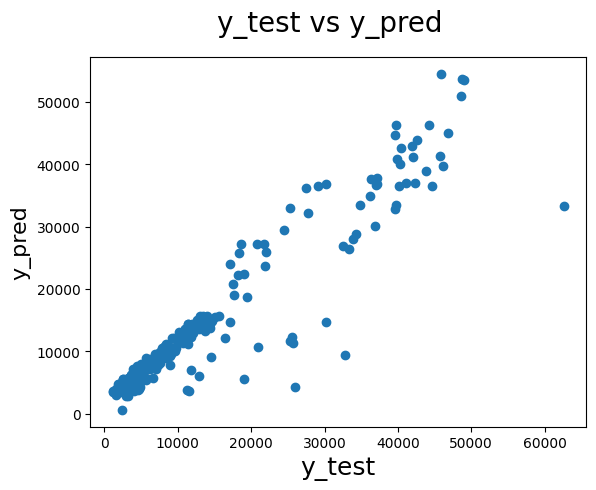

In [31]:
# Plotting y_test and y_pred to understand the spread.
x = model_predict3.toPandas()['expenses']
y = model_predict3.toPandas()['prediction']
fig = plt.figure()
plt.scatter(x,y)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label